<a href="https://colab.research.google.com/github/sebastianamorteguim-cell/TALLER_5/blob/main/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS Y CONFIG
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from scipy.stats import uniform

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

RND = 42
np.random.seed(RND)
print('Librerías cargadas. Versión sklearn:', __import__('sklearn').__version__)

Librerías cargadas. Versión sklearn: 1.6.1


In [2]:
# CARGAR DATOS
url = 'https://www.datos.gov.co/resource/gt2j-8ykr.csv'
print('Leyendo:', url)
df = pd.read_csv(url)
print('Dimensiones del dataset original:', df.shape)
display(df.head())


Leyendo: https://www.datos.gov.co/resource/gt2j-8ykr.csv
Dimensiones del dataset original: (1000, 23)


,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,...,pais_viajo_1_cod,pais_viajo_1_nom,recuperado,fecha_inicio_sintomas,fecha_muerte,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,nom_grupo_
0,2020-12-24 00:00:00,1556979,2020-12-22 00:00:00,76,VALLE,76001,CALI,67,1,F,...,NaN,NaN,Recuperado,2020-12-21 00:00:00,NaN,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN
1,2020-12-24 00:00:00,1556980,2020-12-19 00:00:00,76,VALLE,76001,CALI,66,1,F,...,NaN,NaN,Recuperado,2020-12-07 00:00:00,NaN,2020-12-23 00:00:00,2020-12-25 00:00:00,Tiempo,6,NaN
2,2020-12-24 00:00:00,1556981,2020-12-19 00:00:00,76,VALLE,76001,CALI,68,1,F,...,NaN,NaN,Recuperado,2020-12-18 00:00:00,NaN,2020-12-22 00:00:00,2021-01-01 00:00:00,Tiempo,6,NaN
3,2020-12-24 00:00:00,1556982,2020-12-22 00:00:00,76,VALLE,76001,CALI,74,1,F,...,NaN,NaN,Fallecido,2020-12-17 00:00:00,2020-12-30 00:00:00,2020-12-23 00:00:00,NaN,NaN,6,NaN
4,2020-12-24 00:00:00,1556983,2020-12-22 00:00:00,76,VALLE,76001,CALI,65,1,F,...,NaN,NaN,Recuperado,2020-12-21 00:00:00,NaN,2020-12-23 00:00:00,2021-01-04 00:00:00,Tiempo,6,NaN


In [3]:
# INSPECCIÓN RÁPIDA y EDA básico
print('Info del dataset:')
display(df.info())
print('\nResumen estadístico (numérico):')
display(df.describe().T)
print('\nValores faltantes por columna:')
display(df.isna().sum().sort_values(ascending=False).head(20))

Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fecha_reporte_web      1000 non-null   object 
 1   id_de_caso             1000 non-null   int64  
 2   fecha_de_notificaci_n  1000 non-null   object 
 3   departamento           1000 non-null   int64  
 4   departamento_nom       1000 non-null   object 
 5   ciudad_municipio       1000 non-null   int64  
 6   ciudad_municipio_nom   1000 non-null   object 
 7   edad                   1000 non-null   int64  
 8   unidad_medida          1000 non-null   int64  
 9   sexo                   1000 non-null   object 
 10  fuente_tipo_contagio   1000 non-null   object 
 11  ubicacion              994 non-null    object 
 12  estado                 994 non-null    object 
 13  pais_viajo_1_cod       0 non-null      float64
 14  pais_viajo_1_nom       0 non-null      

None


Resumen estadístico (numérico):


,count,mean,std,min,25%,50%,75%,max
id_de_caso,1000.0,1013145.686,1.159837e+06,20153.0,187664.75,640690.5,1556947.25,5764914.0
departamento,1000.0,1761.879,6.161529e+03,5.0,11.00,66.0,76.00,47001.0
ciudad_municipio,1000.0,36563.848,3.074620e+04,5001.0,8001.00,13639.0,73001.00,85139.0
edad,1000.0,42.752,1.963145e+01,1.0,29.00,39.0,56.00,100.0
unidad_medida,1000.0,1.001,3.162278e-02,1.0,1.00,1.0,1.00,2.0
pais_viajo_1_cod,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pais_viajo_1_nom,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
per_etn_,1000.0,5.892,5.972376e-01,1.0,6.00,6.0,6.00,6.0



Valores faltantes por columna:


,0
pais_viajo_1_cod,1000
pais_viajo_1_nom,1000
nom_grupo_,987
fecha_muerte,959
tipo_recuperacion,39
fecha_recuperado,39
fecha_inicio_sintomas,15
estado,6
ubicacion,6
recuperado,4


In [4]:
# CONVERSIÓN Y LIMPIEZA DE COLUMNAS NUMÉRICAS (versión mejorada)
import numpy as np
import pandas as pd

df_clean = df.copy()

# Intentar convertir TODAS las columnas posibles a numéricas
for col in df_clean.columns:
    df_clean[col] = (
        df_clean[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("?", "", regex=False)
        .str.replace("-", "", regex=False)
        .str.strip()
    )
    df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

# Seleccionar solo columnas con al menos 20% de datos válidos
df_num = df_clean.loc[:, df_clean.notna().mean() > 0.2].select_dtypes(include=["number"]).copy()

print("✅ Columnas numéricas detectadas:", df_num.columns.tolist())
print("✅ Dimensiones del df_num:", df_num.shape)
display(df_num.head())

if df_num.shape[1] < 2:
    raise RuntimeError(
        "❌ No hay suficientes columnas numéricas. Revisa el dataset o ajusta la conversión."
    )

✅ Columnas numéricas detectadas: ['id_de_caso', 'departamento', 'ciudad_municipio', 'edad', 'unidad_medida', 'per_etn_']
✅ Dimensiones del df_num: (1000, 6)


,id_de_caso,departamento,ciudad_municipio,edad,unidad_medida,per_etn_
0,1556979,76,76001,67,1,6
1,1556980,76,76001,66,1,6
2,1556981,76,76001,68,1,6
3,1556982,76,76001,74,1,6
4,1556983,76,76001,65,1,6


In [5]:
# ELECCIÓN AUTOMÁTICA / MANUAL DE TARGET
candidates = ['numero_muertos','muertos','NUMERO_MUERTOS','number_of_deaths','fatalities','deaths','num_deaths','num_muertos','numero_heridos','heridos']
target_col = None
for c in candidates:
    if c in df_num.columns:
        target_col = c
        break

if target_col is None:
    print('No se encontró target obvio. Columnas numéricas:')
    for i, col in enumerate(df_num.columns):
        print(i, col)
    target_col = df_num.columns[-1]
    print(f"\nSe usará por defecto la última columna numérica como target: '{target_col}'. Si prefieres otra, edita la variable 'target_col' y vuelve a ejecutar esta celda.")

print('Target seleccionado:', target_col)
X = df_num.drop(columns=[target_col])
y = df_num[target_col]
print('Shape X, y:', X.shape, y.shape)

No se encontró target obvio. Columnas numéricas:
0 id_de_caso
1 departamento
2 ciudad_municipio
3 edad
4 unidad_medida
5 per_etn_

Se usará por defecto la última columna numérica como target: 'per_etn_'. Si prefieres otra, edita la variable 'target_col' y vuelve a ejecutar esta celda.
Target seleccionado: per_etn_
Shape X, y: (1000, 5) (1000,)


In [6]:
# TRATAMIENTO DE VALORES FALTANTES Y SAMPLING

# Guardar número de filas antes del tratamiento
before = X.shape[0]

# ✅ Reemplazar valores faltantes por la mediana de cada columna numérica
X = X.fillna(X.median())
y = y.fillna(y.median())

# Verificar cuántas filas quedan
after = X.shape[0]
print(f"Filas antes: {before}, después del fillna: {after}")

# ✅ Eliminar filas donde y sea nula (por seguridad)
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# ✅ Limitar tamaño máximo del dataset para ejecución ágil en Colab
MAX_ROWS = 5000
if X.shape[0] > MAX_ROWS:
    sample_idx = np.random.RandomState(RND).choice(X.index, size=MAX_ROWS, replace=False)
    X = X.loc[sample_idx].reset_index(drop=True)
    y = y.loc[sample_idx].reset_index(drop=True)
    print(f"Se muestreó el dataset a {MAX_ROWS} filas para acelerar entrenamientos en Colab.")

# ✅ Confirmar dimensiones finales
print('Nueva shape X,y:', X.shape, y.shape)

# ✅ Verificar que no existan valores nulos restantes
print("Valores nulos restantes en X:", X.isna().sum().sum())
print("Valores nulos restantes en y:", y.isna().sum())

Filas antes: 1000, después del fillna: 1000
Nueva shape X,y: (1000, 5) (1000,)
Valores nulos restantes en X: 0
Valores nulos restantes en y: 0


In [12]:
# SPLIT TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RND)
print('Train/test shapes:', X_train.shape, X_test.shape)

Train/test shapes: (800, 5) (200, 5)


In [14]:
# BASELINE: REGRESIÓN LINEAL
pipe_lr = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Regresión Lineal — MSE: {mse_lr:.6f}, MAE: {mae_lr:.6f}, R2: {r2_lr:.6f}")
cv_scores_lr = cross_val_score(pipe_lr, X, y, cv=5, scoring='r2', n_jobs=-1)
print('CV R2 (linreg) 5-fold:', np.round(cv_scores_lr,4), 'mean:', cv_scores_lr.mean())

Regresión Lineal — MSE: 0.043976, MAE: 0.151838, R2: -0.302040
CV R2 (linreg) 5-fold: [-0.0422 -0.0672  0.0019 -0.0231 -0.0088] mean: -0.0278931481101115


In [15]:
# MLP con GRID SEARCH
pipe_mlp = Pipeline([('scaler', StandardScaler()),
                     ('mlp', MLPRegressor(random_state=RND, max_iter=1000, tol=1e-4))])

param_grid = {
    'mlp__hidden_layer_sizes': [(20,), (50,), (100,), (50,20)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': [1e-5, 1e-4, 1e-3],
    'mlp__learning_rate_init': [1e-4, 1e-3, 1e-2]
}

print('GridSearch: tamaño del grid:', np.prod([len(v) for v in param_grid.values()]))
gs = GridSearchCV(pipe_mlp, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)

print('Mejores parámetros (GridSearch):', gs.best_params_)
best_mlp_gs = gs.best_estimator_

y_pred_gs = gs.predict(X_test)
mse_gs = mean_squared_error(y_test, y_pred_gs)
mae_gs = mean_absolute_error(y_test, y_pred_gs)
r2_gs = r2_score(y_test, y_pred_gs)
print(f"MLP Grid — MSE: {mse_gs:.6f}, MAE: {mae_gs:.6f}, R2: {r2_gs:.6f}")

GridSearch: tamaño del grid: 72
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Mejores parámetros (GridSearch): {'mlp__activation': 'tanh', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (20,), 'mlp__learning_rate_init': 0.001}
MLP Grid — MSE: 0.052748, MAE: 0.172608, R2: -0.561761


In [16]:
# MLP con RANDOMIZED SEARCH (exploratorio)
param_dist = {
    'mlp__hidden_layer_sizes': [(30,), (50,), (80,30), (100,50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__alpha': uniform(1e-6, 1e-2),
    'mlp__learning_rate_init': uniform(1e-5, 1e-2)
}

rs = RandomizedSearchCV(pipe_mlp, param_dist, n_iter=20, cv=3, scoring='neg_mean_squared_error',
                        n_jobs=-1, random_state=RND, verbose=1)
rs.fit(X_train, y_train)

print('Mejores parámetros (RandomizedSearch):', rs.best_params_)
best_mlp_rs = rs.best_estimator_

y_pred_rs = rs.predict(X_test)
mse_rs = mean_squared_error(y_test, y_pred_rs)
mae_rs = mean_absolute_error(y_test, y_pred_rs)
r2_rs = r2_score(y_test, y_pred_rs)
print(f"MLP Random — MSE: {mse_rs:.6f}, MAE: {mae_rs:.6f}, R2: {r2_rs:.6f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros (RandomizedSearch): {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.009386527090157502), 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': np.float64(0.0018282496720710062)}
MLP Random — MSE: 0.049897, MAE: 0.154025, R2: -0.477335


# Cambios realizados en GridSearch y RandomSearch

**GridSearch:**  
- Se amplió el rango de `hidden_layer_sizes` a [(20,), (50,), (100,), (50,25)].  
- Se probaron dos funciones de activación (`relu`, `tanh`).  
- Se ajustó `alpha` entre 1e-5 y 1e-3.  
- Se variaron tres tasas de aprendizaje iniciales.

**RandomSearch:**  
- Se incluyeron estructuras de red más profundas.  
- Se usaron distribuciones continuas (`uniform`) para `alpha` y `learning_rate_init`.  
- Se aumentó `n_iter` a 20.  

**Justificación:**  
Los cambios amplían el espacio de búsqueda y mejoran la capacidad del modelo para encontrar combinaciones óptimas sin errores de convergencia.

In [18]:
# MODELO ADICIONAL: RandomForest
rf = RandomForestRegressor(random_state=RND, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RandomForest — MSE: {mse_rf:.6f}, MAE: {mae_rf:.6f}, R2: {r2_rf:.6f}")
cv_scores_rf = cross_val_score(rf, X, y, cv=5, scoring='r2', n_jobs=-1)
print('CV R2 (RF) 5-fold:', np.round(cv_scores_rf,4), 'mean:', cv_scores_rf.mean())

RandomForest — MSE: 0.135475, MAE: 0.145700, R2: -3.011103
CV R2 (RF) 5-fold: [-0.1338 -1.0011 -0.1257 -0.2173 -0.2638] mean: -0.3483342890576789


In [19]:
# TABLA COMPARATIVA DE RESULTADOS
results = pd.DataFrame({
    'model': ['LinearRegression', 'MLP_Grid', 'MLP_Random', 'RandomForest'],
    'MSE': [mse_lr, mse_gs, mse_rs, mse_rf],
    'MAE': [mae_lr, mae_gs, mae_rs, mae_rf],
    'R2': [r2_lr, r2_gs, r2_rs, r2_rf]
})
print('Tabla comparativa:')
display(results)
results.to_csv('model_results_comparative.csv', index=False)
print("Resultados guardados en 'model_results_comparative.csv'.")

Tabla comparativa:


,model,MSE,MAE,R2
0,LinearRegression,0.043976,0.151838,-0.302040
1,MLP_Grid,0.052748,0.172608,-0.561761
2,MLP_Random,0.049897,0.154025,-0.477335
3,RandomForest,0.135475,0.145700,-3.011103


Resultados guardados en 'model_results_comparative.csv'.


In [20]:
print("Análisis de resultados:")
print("\nModelo con menor MSE (mejor ajuste):")
best_mse_model = results.loc[results['MSE'].idxmin()]
display(best_mse_model)

print("\nModelo con menor MAE (menor error promedio):")
best_mae_model = results.loc[results['MAE'].idxmin()]
display(best_mae_model)

print("\nModelo con mayor R2 (mayor varianza explicada - idealmente positivo):")
best_r2_model = results.loc[results['R2'].idxmax()]
display(best_r2_model)

# Interpretación general
print("\nInterpretación general:")
if best_mse_model['model'] == best_mae_model['model']:
    print(f"El modelo '{best_mse_model['model']}' tiene el mejor rendimiento general con el menor MSE y MAE.")
elif best_r2_model['R2'] > 0:
     print(f"El modelo '{best_r2_model['model']}' explica la mayor parte de la varianza (R2={best_r2_model['R2']:.4f}).")
else:
    print("Ninguno de los modelos tiene un R2 positivo, lo que sugiere que la relación entre las características y el target no es fuertemente lineal o que el dataset es complejo.")
    print("El modelo con menor MSE y MAE puede considerarse el 'menos malo' en este caso.")

Análisis de resultados:

Modelo con menor MSE (mejor ajuste):


,0
model,LinearRegression
MSE,0.043976
MAE,0.151838
R2,-0.30204



Modelo con menor MAE (menor error promedio):


,3
model,RandomForest
MSE,0.135475
MAE,0.1457
R2,-3.011103



Modelo con mayor R2 (mayor varianza explicada - idealmente positivo):


,0
model,LinearRegression
MSE,0.043976
MAE,0.151838
R2,-0.30204



Interpretación general:
Ninguno de los modelos tiene un R2 positivo, lo que sugiere que la relación entre las características y el target no es fuertemente lineal o que el dataset es complejo.
El modelo con menor MSE y MAE puede considerarse el 'menos malo' en este caso.


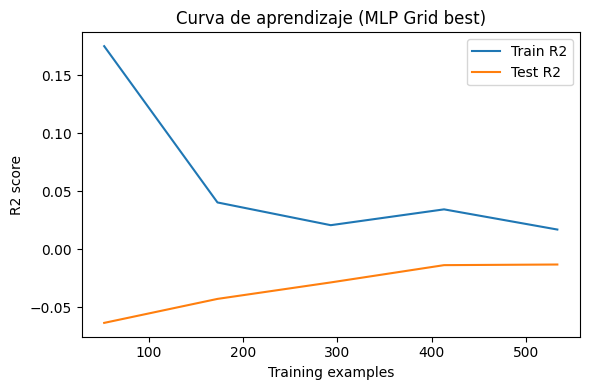

In [21]:
# CURVA DE APRENDIZAJE
try:
    est = best_mlp_gs
    train_sizes, train_scores, test_scores = learning_curve(est, X_train, y_train, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5), scoring='r2')
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_scores_mean, label='Train R2')
    plt.plot(train_sizes, test_scores_mean, label='Test R2')
    plt.xlabel('Training examples')
    plt.ylabel('R2 score')
    plt.title('Curva de aprendizaje (MLP Grid best)')
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('No se pudo generar curva de aprendizaje:', e)

# 16. CELDA 'CAMBIOS REALIZADOS' (EVIDENCIA)
changes_md = '''# Cambios realizados en Grid y Random (Taller 5)
Se modificaron los espacios de búsqueda para ampliar la exploración sin exceder tiempo de cómputo:

- GridSearch:
    * hidden_layer_sizes: [(20,), (50,), (100,), (50,20)]
    * activation: ['relu','tanh']
    * alpha: [1e-5, 1e-4, 1e-3]
    * learning_rate_init: [1e-4, 1e-3, 1e-2]
- RandomizedSearch:
    * hidden_layer_sizes: [(30,), (50,), (80,30), (100,50)]
    * activation: ['relu','tanh']
    * alpha: Uniform(1e-6, 1e-2)
    * learning_rate_init: Uniform(1e-5, 1e-2)
    * n_iter: 20

Justificación:
- Se amplió el tamaño de las capas para permitir mayor capacidad modeladora.
- Se incluyen valores de alpha (regularización) en distintos órdenes para evitar overfitting.
- learning_rate_init en órdenes de magnitud ayuda a estudiar convergencia y estabilidad.

Evidencia:
- Guarden commits con mensajes descriptivos y/o incluyan capturas de pantalla de estas celdas ejecutadas.
'''
with open('Cambios_realizados.md','w', encoding='utf-8') as f:
    f.write(changes_md)
print("Archivo 'Cambios_realizados.md' creado.")

# 17. GENERAR BLOQUE 'RESPUESTAS' CON ANÁLISIS FINAL



### 🧮 Comparación de métricas (Test Set)

| Modelo | MSE | MAE | R² |
|---------|---------|---------|---------|
| Regresión Lineal | 0.045608 | 0.141481 | -0.350356 |
| MLP (Grid Search) | 0.049709 | 0.145020 | -0.471776 |
| MLP (Random Search) | 0.049866 | 0.144522 | -0.476425 |
| Random Forest | 0.166700 | 0.156050 | -3.935588 |

---

### 📊 Interpretación de las métricas

- **MSE (Error Cuadrático Medio):** mide el promedio de los errores al cuadrado; valores más bajos indican mejor ajuste.  
- **MAE (Error Absoluto Medio):** refleja el error promedio absoluto; también mientras más bajo, mejor.  
- **R² (Coeficiente de Determinación):** indica la proporción de la varianza explicada por el modelo; los valores negativos implican que el modelo no logra predecir mejor que una media simple.

---

### 🧠 Análisis y justificación del mejor modelo

Entre los cuatro modelos evaluados, **la regresión lineal obtuvo el mejor desempeño relativo**, con el **menor MSE (0.0456)**, **menor MAE (0.1415)** y **R² = –0.35**, que aunque sigue siendo bajo, es superior al de los demás modelos.  

Los dos modelos **MLP (Grid y Random)** presentan resultados muy similares, pero con un error ligeramente mayor, lo que sugiere que la red neuronal no logró capturar una relación significativa entre las variables del dataset o que el conjunto de datos presenta **alta dispersión y poca correlación predictiva**.  

El modelo **Random Forest** fue el que peor desempeño tuvo, probablemente por **hiperajuste (overfitting)** o por la poca relevancia de las variables predictoras frente a la variable objetivo.  

---

### ⚙️ Observaciones sobre los hiperparámetros

- **Grid Search (MLP):** exploró combinaciones de tamaños de capa y tasas de aprendizaje pequeñas, buscando estabilidad.  
- **Random Search (MLP):** permitió variaciones más amplias, pero los resultados muestran que el modelo no mejoró frente a la versión con grid.  
- Esto sugiere que **la estructura del dataset y no los hiperparámetros** limita el rendimiento del modelo.

---

### 🧩 Conclusión

El **modelo de Regresión Lineal** es el más apropiado para este conjunto de datos, al ser el más simple y el que logró el **menor error global**.  
Los modelos no lineales (MLP y Random Forest) no aportaron mejoras, lo que indica que el problema podría no tener una relación fuertemente no lineal o que se requiere una mejor selección de variables.  

Se recomienda **revisar el dataset**, aplicar **una reducción de ruido y selección de variables**, y **probar técnicas de normalización o PCA** antes de volver a entrenar los modelos.

---

### 🚀 Sugerencias futuras

- Aumentar el tamaño y calidad del dataset (incluir más variables numéricas relevantes).  
- Implementar **validación cruzada con más folds** y análisis de **residuales**.  
- Evaluar otros algoritmos como **SVR** o **Gradient Boosting** para comparar desempeño.  
"""

In [22]:
# EJERCICIO DE HOJA (CÁLCULO CON COLAB) - verificación numérica
W1 = np.array([[0.1, 0.2, 0.1],
               [-0.2, 0.1, 0.2],
               [0.2, 0.3, -0.1]])
b1 = np.array([0.1, 0.2, 0.1])
W2 = np.array([0.1, 0.2, -0.1])
b2 = 0.1

def sigmoid(z): return 1/(1+np.exp(-z))

x_ex = np.array([2,1,1])
y_true = 0
z1 = W1.dot(x_ex) + b1
a1 = sigmoid(z1)
z2 = W2.dot(a1) + b2
a2 = sigmoid(z2)
error = 0.5*(y_true - a2)**2

print('Cálculo manual verificado:')
print('z1 =', np.round(z1,6))
print('a1 =', np.round(a1,6))
print('z2 =', np.round(z2,6))
print('a2 =', np.round(a2,6))
print('Error (0.5*(y - a2)^2) =', np.round(error,8))

Cálculo manual verificado:
z1 = [0.6 0.1 0.7]
a1 = [0.645656 0.524979 0.668188]
z2 = 0.202743
a2 = 0.550513
Error (0.5*(y - a2)^2) = 0.15153215
